# Notebook to detect objects(burial mounds) on GIS Data

This notebook detects burial mounds on a given image of a map using the trained YOLO v8 model produced by train_YOLO.ipynb. This YOLO detection notebook works best when run in Google Colab. When run in Google Colab, the model is able to make predictions on any given image.

NOTE: paths found in this notebook are absolute Google Drive paths. User may need to change the paths specific to their Google Drive paths as Google Colab notebook only works with absolute paths to one's Google Drive directories.

# Google Colab Additional Steps
The next 3 steps are additional steps to be done when running in Google Colab. User may skip the steps if notebook is run locally.


In [1]:
#installing ultralytics since when run in Google Colab, we have to install on each runtime
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.2/699.2 kB 4.9 MB/s eta 0:00:00


In [2]:
#installing rasterio
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 38.2 MB/s eta 0:00:00


In [3]:
#mounted my google drive where the dataset is located
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#imported ultralytics and performed checks to ensure YOLO can run
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.4/166.8 GB disk)


In [5]:
#imported YOLO
from ultralytics import YOLO

# Splits
Now, before we proceed to detection, recall that during data preprocessing, we performed splits on the images. Since the model trained on these cropped images, then the model should also be used to perform detections on images of the same size as the cropped images for best results. With this said, for the next steps we will first be splitting the image to be processed in the same manner that the training data was split.

In [6]:
#imported necessary packages
import rasterio
from rasterio.windows import Window
import os

In [7]:
#defined the same function as the one found in data_Preprocessing that will split images when called

def split_images(geotiff_path,rows,columns):#function requires a directory path for the geotiff images that will be provided with labels

    path_parts = geotiff_path.split('/')
    filename = path_parts[-1]

    #Succeeding steps aim to get just the filename without the .tif extension.
    #Split the filename based on the dot ('.') character
    filename_parts = filename.split('.')

    #Got the part before the extension
    actual_filename = filename_parts[0]

    with rasterio.open(geotiff_path) as src:
        #specified the number of rows and columns for the grid
        num_rows, num_cols = rows, columns

        #calculated the width and height of each subset
        subset_width = src.width // num_cols
        subset_height = src.height // num_rows

        #iterated over rows and columns to create and save each subset
        for row in range(num_rows):
            for col in range(num_cols):
                #calculated the window bounds for each subset
                window = Window(col * subset_width, row * subset_height, subset_width, subset_height)

                #read the data for the subset
                subset_data = src.read(window=window)

                destination_folder = '/content/drive/MyDrive/summer_internship/for_detection_split_images'
                if not os.path.exists(destination_folder):
                    os.makedirs(destination_folder)

                #created geotiff file for each subset
                output_path = f'{destination_folder}/{actual_filename}_{row}_{col}.tif'
                with rasterio.open(output_path, 'w', driver='GTiff', height=subset_height, width=subset_width, count=src.count, dtype=src.dtypes[0], crs=src.crs, transform=src.window_transform(window)) as dst:
                    dst.write(subset_data)

                print(f"Subset {row + 1}-{col + 1} saved to {output_path}")


Now, recall that from our data_Preprocessing notebook, we removed one image to be excluded from all the sets. We will finally be using that image in this notebook. For a truly unbiased result, we will be instructing the trained model to make predictions on this excluded image.

In [ ]:
#called the function above to split the excluded image
split_images("/content/drive/MyDrive/summer_internship/data/YambolGIS/Training32635/K-35-066-3_Razdel35.tif",
             6,6)

Subset 1-1 saved to /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_0.tif
Subset 1-2 saved to /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_1.tif
Subset 1-3 saved to /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_2.tif
Subset 1-4 saved to /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_3.tif
Subset 1-5 saved to /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_4.tif
Subset 1-6 saved to /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_5.tif
Subset 2-1 saved to /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_1_0.tif
Subset 2-2 saved to /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_1_1.tif
Subset 2-3 saved to /content/drive/MyDrive/summer_internship/for_detecti

## Detect

To test how well the model performs, in the next steps, we will be using the trained model to make predictions on each cropped image created above. We will be conducting this with the help of a loop that repeatedly calls a function that performs YOLO detection on a given image.

In [8]:
#defined function that instructs the trained model to detect

def detect(geotiff_path):
  #Loaded the trained model from train_YOLO.ipynb
  model = YOLO('/content/drive/MyDrive/summer_internship/training_results/train/weights/best.pt')
  results = model(source = f"{geotiff_path}",
                  show = True, save = True)


In [9]:
#assigns the path to the images that were split above
geotiff_dir = '/content/drive/MyDrive/summer_internship/for_detection_split_images'

#iterates through all images found in the given directory
for image in os.listdir(geotiff_dir):
  #Opened the file using rasterio
  geotiff_path = os.path.join(geotiff_dir, image)
  #calls the detect function above
  detect(geotiff_path)


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_0.tif: 576x640 (no detections), 86.8ms
Speed: 12.1ms preprocess, 86.8ms inference, 112.6ms postprocess per image at shape (1, 3, 576, 640)
Results saved to runs/detect/predict
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_1.tif: 576x640 (no detections), 10.0ms
Speed: 6.0ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)
Results saved to runs/detect/predict2
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/MyDrive/summer_internship/for_detection_split_images/K-35-066-3_Razdel35_0_2.tif: 576x640 (no detections), 10.7ms
Speed: 3.5ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3,

Next, similar to what we did when we trained the model, we will also be saving the detection results in our Google Drive so we can easily view the results.

In [10]:
#imported packages that will enable the copying of the training results to google drive
import os
import shutil

#set the path where the detection results will be saved
output_drive_path = '/content/drive/MyDrive/summer_internship/detection_results'

#assigned the temporary Google Colab folder where results are saved to the source directory
source_directory = '/content/runs/detect'

#set the output_drive_path as the destination directory
destination_directory = output_drive_path

#Creates the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

#Copied all contents from the source directory to the destination directory
shutil.copytree(source_directory, os.path.join(destination_directory, os.path.basename(source_directory)))


'/content/drive/MyDrive/summer_internship/detection_results/detect'

# Merge

Next, now that we have predictions on each cropped image, in order for us to have a view of the whole image, we will be putting these cropped images together and merge them into one single image.

In [11]:
#imported necessary packages
import rasterio
from rasterio.windows import Window

#specified the number of rows and columns for the grid
num_rows, num_cols = 6, 6

#assigned the path for the merged image
merged_output_path = 'merged_image.tif'

#initialized a list to store subset paths
subset_paths = []

#iterated over rows and columns to read each subset
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        if count == 0:
          pred_num = ''
        else:
          pred_num = count + 1
        #specified the path to each subset
        subset_path = f'/content/drive/MyDrive/summer_internship/detection_results/detect/predict{pred_num}/K-35-066-3_Razdel35_{row}_{col}.tif'
        subset_paths.append(subset_path)
        count = count + 1

#created an empty list to store rasterio windows
windows = []

#iterated over the subset paths to get windows
for subset_path in subset_paths:
    with rasterio.open(subset_path) as subset_src:
      windows.append(Window(0, 0, subset_src.width, subset_src.height))

#opened the first subset to get its information
with rasterio.open(subset_paths[0]) as first_subset_src:
    #created a geotiff file for the merged image
    with rasterio.open(
        merged_output_path,
        'w',
        driver='GTiff',
        height=first_subset_src.height * num_rows,
        width=first_subset_src.width * num_cols,
        count=first_subset_src.count,
        dtype=first_subset_src.dtypes[0],
        crs=first_subset_src.crs,
        transform=first_subset_src.transform,
    ) as merged_dst:
        #iterated over rows and columns to write each subset to the merged Geotiff image
        for row in range(num_rows):
            for col in range(num_cols):
                #specified the path to each subset
                subset_path = subset_paths[row * num_cols + col]

                #read the data for the subset
                with rasterio.open(subset_path) as subset_src:
                    #got the window of the first band
                    window = windows[row * num_cols + col]
                    subset_data = subset_src.read(window=window)

                    #calculated the window bounds for each subset in the merged image
                    window_bounds = Window(
                        col * first_subset_src.width,
                        row * first_subset_src.height,
                        first_subset_src.width,
                        first_subset_src.height,
                    )

                    #wrote the subset data to the merged Geotiff image
                    merged_dst.write(subset_data, window=window_bounds)

print(f"Merged image saved to {merged_output_path}")



/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Merged image saved to merged_image.tif


# Plot

Next, we will display the result of the detection and the merge.

In [12]:
#Imported necessary packages to show the result of the detection
import numpy as np
from matplotlib import pyplot as plt

In [13]:
#Read the file of the detection result

img = plt.imread('/content/merged_image.tif')

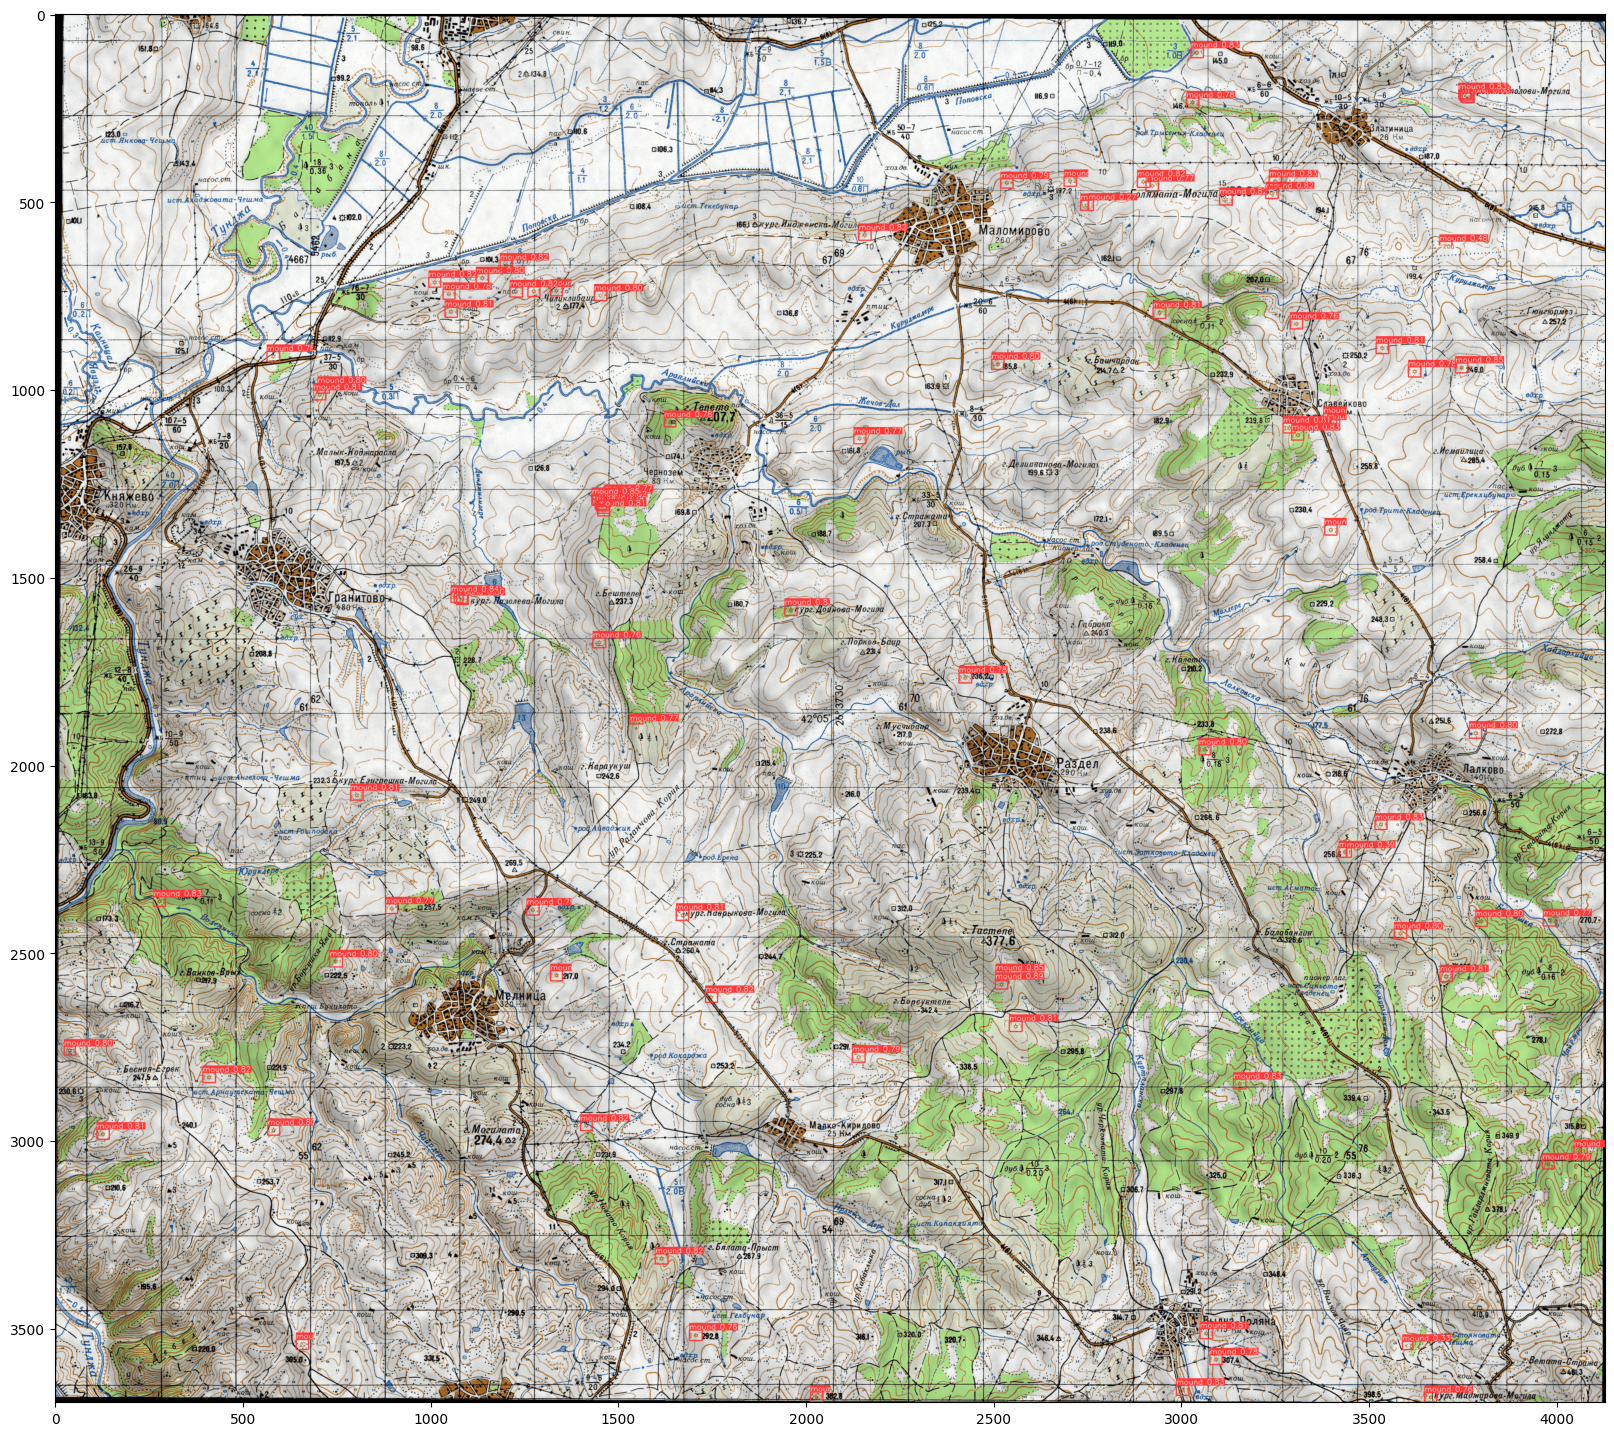

In [14]:
#displayed the image showing the result of the detection
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img)
plt.show()

# Test Set Evaluation

For the last part of this notebook, we will be performing an evaluation of the trained model's performance on the test dataset.

In [15]:
!yolo task=detect val mode=val model='/content/drive/MyDrive/summer_internship/training_results/train/weights/best.pt' data='/content/drive/MyDrive/summer_internship/detect_data.yaml'


Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
100% 755k/755k [00:00<00:00, 27.0MB/s]
val: Scanning /content/drive/.shortcut-targets-by-id/1fs0dPYE2LSV-MIvSUUs2UEqqmD_QzwqC/summer_internship/data_images/test/labels... 69 images, 30 backgrounds, 0 corrupt: 100% 69/69 [00:39<00:00,  1.74it/s]
val: New cache created: /content/drive/.shortcut-targets-by-id/1fs0dPYE2LSV-MIvSUUs2UEqqmD_QzwqC/summer_internship/data_images/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:10<00:00,  2.17s/it]
                   all         69        138      0.957      0.975      0.965      0.664
Speed: 5.2ms preprocess, 10.2ms inference, 0.0ms loss, 10.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


Here, we can see that the model has high P, R, and MAP 50 values which means that it is performing well on objects that are easy to be detected but we can see that the MAP 50-95 values are significantly and relatively lower which means that the model does not perform that well as the difficulty of predictions increase.
